# 3. Ligand-based screening

## Understanding Molecular Similarity:

The concept of molecular similarity forms the foundation of our search for new drugs. It's based on the similar property principle (SPP) and structure-activity relationship (SAR), which postulate that molecules with similar structures often exhibit similar properties and biological activities.

## Encoding molecules

To compare molecules effectively, we need to encode them into a form suitable for computational analysis. This is achieved using molecular descriptors and fingerprints.

<b>Molecular descriptors:</b> These capture various aspects of a molecule, such as its 1D descriptors (e.g., molecular weight, logP, melting point) or 2D descriptors (e.g., molecular graphs, paths, fragments, atom environments). Additionally, 3D descriptors (e.g., shape, stereochemistry) can be used, but their applicability may be limited due to molecular flexibility.

<b>Fingerprints:</b> These act as unique identifiers for molecules, similar to fingerprints used for human identification. They typically represent molecules as bitstrings or bitvectors, where each bit corresponds to a specific molecular substructure or environment. A "1" in the bit indicates the presence, while a "0" indicates the absence of that feature. Some fingerprints, like MACCS keys (consisting of 166 predefined fragments), are simple and interpretable, while others, like Morgan fingerprints (representing circular environments of atoms), offer more flexibility.

## Comparing molecules

Once molecules are encoded, we can compare their similarities using various molecular similarity measures. Two commonly used measures are the Tanimoto coefficient and the Dice index. These coefficients quantify the similarity by considering the number of shared features (bits set to "1") between two fingerprints relative to the total number of features.

## Virtual Screening

In the early stages of drug discovery, a crucial challenge lies in identifying promising drug candidates from a vast pool of small molecules. This process, called virtual screening (or high-throughput screening), involves filtering large libraries of molecules based on specific criteria.

One powerful application of molecular similarity is similarity search within virtual screening. We can compare a set of novel molecules against known active molecules (e.g., an existing drug or a molecule known to bind to the target of interest). Molecules with the highest similarity scores, based on calculated similarity coefficients, are then prioritized for further evaluation.

## Validating the results

To assess the effectiveness of virtual screening, we utilize enrichment plots. These plots visualize the proportion of active molecules identified within the top ranked percentage of the screened library. A higher enrichment at the top of the list indicates a successful virtual screening process, suggesting that the method effectively prioritizes molecules with the desired biological activity.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
    AllChem,
    rdMolDescriptors,
)

## Import Load known active molecules that bind to PIK3CA

Here are some active molecules that bind to PIK3CA:


<b>Buparlisib (GSK283881):</b> This is a selective inhibitor of PI3K alpha. It is used in combination with fulvestrant to treat postmenopausal women and men with hormone receptor-positive, HER2-negative, advanced or metastatic breast cancer who have received prior endocrine therapy.

<b>Umbrelisib (Bylvay):</b> This is a PI3K delta inhibitor that is used to treat patients with marginal zone lymphoma.

<b>Duvelisib (Copiktra):</b> This is a PI3K delta inhibitor that is used to treat patients with chronic lymphocytic leukemia (CLL) and follicular lymphoma.

<b>SF1126:</b> This is a pan-PI3K inhibitor that is in clinical trials for a variety of cancers.


In [2]:
# Molecules in SMILES format
molecule_smiles = [
    "CC(C)N1CCN(CC1)c2ccc(cc2F)C(=O)Nc3ccc4c(c3)NC(=O)N(C4)C5CCC(CC5)N6CCOCC6",
    "CC(C)Nc1nc(nc(n1)c2ccccc2C#N)N3CCN(CC3)c4cc(cnc4)Cl",
    "CC(C)Nc1nc(nc(n1)c2ccc(cc2)Cl)c3ccnc(n3)N4CCN(CC4)C5CCC(CC5)N6CCOCC6",
    "COC(=O)[C@@H]1CN(CC1)Cc2ccc(cc2)Nc3nc(nc(n3)c4ccc(cc4)F)c5ccc(cc5)F",
]

# List of molecule names
molecule_names = [
    "Buparlisib",
    "Umbrelisib ",
    "Duvelisib",
    "SF1126",
]

,smiles,name,ROMol
0,CC(C)N1CCN(CC1)c2ccc(cc2F)C(=O)Nc3ccc4c(c3)NC(...,Buparlisib,
1,CC(C)Nc1nc(nc(n1)c2ccccc2C#N)N3CCN(CC3)c4cc(cn...,Umbrelisib,
2,CC(C)Nc1nc(nc(n1)c2ccc(cc2)Cl)c3ccnc(n3)N4CCN(...,Duvelisib,
3,COC(=O)[C@@H]1CN(CC1)Cc2ccc(cc2)Nc3nc(nc(n3)c4...,SF1126,

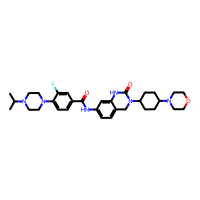
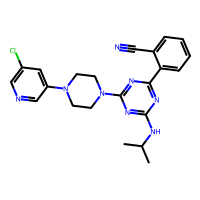
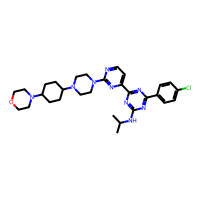
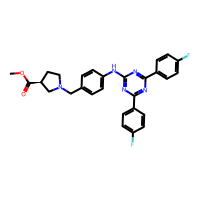

In [42]:
molecules = pd.DataFrame({"smiles": molecule_smiles, "name": molecule_names})
PandasTools.AddMoleculeColumnToFrame(molecules, smilesCol="smiles")
PandasTools.RenderImagesInAllDataFrames(True)

# Show molecules
molecules.head()

## Calculate molecular descriptors

<li>1D descriptor</li>

In [4]:
molecules["molecule_weight"] = molecules.ROMol.apply(Descriptors.MolWt)

# Sort molecules by molecular weight
molecules.sort_values(["molecule_weight"], ascending=False, inplace=True)
molecules[["smiles", "name", "molecule_weight"]]

,smiles,name,molecule_weight
0,CC(C)N1CCN(CC1)c2ccc(cc2F)C(=O)Nc3ccc4c(c3)NC(...,Buparlisib,578.733
2,CC(C)Nc1nc(nc(n1)c2ccc(cc2)Cl)c3ccnc(n3)N4CCN(...,Duvelisib,578.165
3,COC(=O)[C@@H]1CN(CC1)Cc2ccc(cc2)Nc3nc(nc(n3)c4...,SF1126,501.537
1,CC(C)Nc1nc(nc(n1)c2ccccc2C#N)N3CCN(CC3)c4cc(cn...,Umbrelisib,434.935


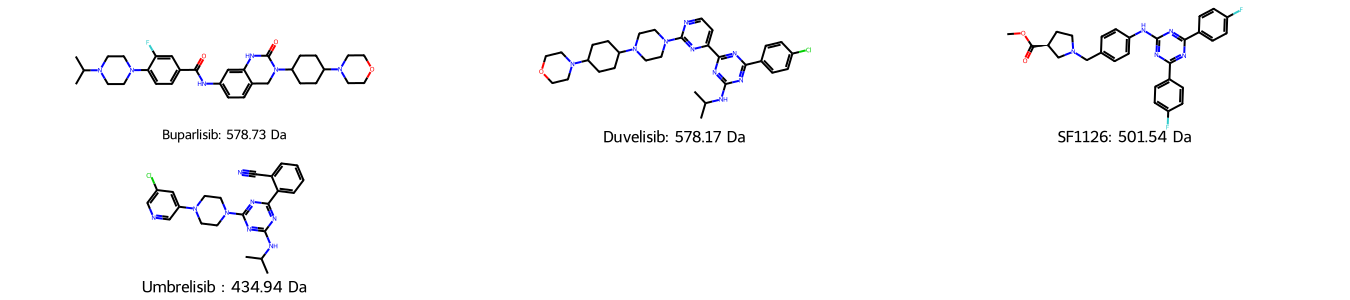

In [5]:
Draw.MolsToGridImage(
    molecules["ROMol"],
    legends=[
        f"{molecule['name']}: {molecule['molecule_weight']:.2f} Da"
        for index, molecule in molecules.iterrows()
    ],
    subImgSize=(450, 150),
    molsPerRow=3,
)

<li> 2D descriptors: MACCS fingerprint</li>

In [6]:
molecules["maccs"] = molecules.ROMol.apply(MACCSkeys.GenMACCSKeys)

<li> 2D descriptors: Morgan fingerprint</li>

,smiles,name,ROMol,morgan
0,CC(C)N1CCN(CC1)c2ccc(cc2F)C(=O)Nc3ccc4c(c3)NC(...,Buparlisib,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(C)Nc1nc(nc(n1)c2ccccc2C#N)N3CCN(CC3)c4cc(cn...,Umbrelisib,,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC(C)Nc1nc(nc(n1)c2ccc(cc2)Cl)c3ccnc(n3)N4CCN(...,Duvelisib,,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COC(=O)[C@@H]1CN(CC1)Cc2ccc(cc2)Nc3nc(nc(n3)c4...,SF1126,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

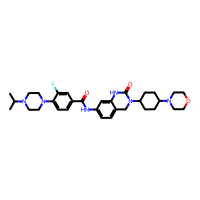
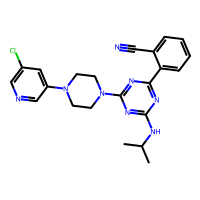
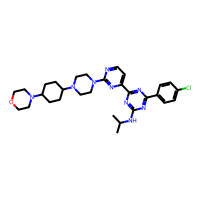
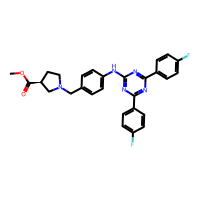

In [44]:
# Define a function to generate Morgan fingerprints
def generate_morgan_fingerprint(mol):
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)

# Apply the function to generate Morgan fingerprints for each molecule
molecules['morgan'] = molecules['ROMol'].apply(generate_morgan_fingerprint)
molecules.head()

## Calculate molecular similarity

The primary goal is to compare different molecules and quantify how similar they are to each other. This is a fundamental task in drug discovery, where new molecules are evaluated against known compounds to gauge their potential activity or therapeutic similarity.

### Techniques

<b>Molecular Fingerprints:</b> Rather than comparing complex molecular structures directly, the process utilizes simplified representations called fingerprints.

<li>MACCS Keys: A type of fingerprint consisting of predefined structural fragments or substructures. If a specific fragment is present in a molecule, its corresponding bit in the fingerprint is set to '1', otherwise '0'.</li>
<li>Morgan Fingerprints: A more flexible fingerprint type that captures circular neighborhoods around each atom in the molecule. These neighborhoods are encoded into a bit vector.</li>

<b>Similarity Measures:</b> Mathematical formulas used to quantify how similar two fingerprints are.

<li>Tanimoto Similarity: One of the most common similarity measures. It's calculated by dividing the number of bits in common between two fingerprints by the total number of bits that are 'on' in either fingerprint.</li>
<li>Dice Similarity: Very similar to Tanimoto, the main difference is that in the Dice coefficient, the number of common bits is multiplied by two in the numerator.</li>

### MACCS fingerprints: Tanimoto similarity and Dice similarity

In [8]:
# Define molecule query and list
molecule_query = molecules["maccs"][0]
molecule_list = molecules["maccs"].to_list()

# Calculate similarty values between query and list elements
molecules["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_maccs"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

In [9]:
preview = molecules.sort_values(["tanimoto_maccs"], ascending=False).reset_index()
preview[["name", "tanimoto_maccs", "dice_maccs"]]

,name,tanimoto_maccs,dice_maccs
0,Buparlisib,1.000000,1.000000
1,Duvelisib,0.647887,0.786325
2,Umbrelisib,0.583333,0.736842
3,SF1126,0.558442,0.716667


In [10]:
def draw_ranked_molecules(molecules, sort_by_column):
    """
    Draw molecules sorted by a given column.

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules (with "ROMol" and "name" columns and a column to sort by.
    sort_by_column : str
        Name of the column used to sort the molecules by.

    Returns
    -------
    Draw.MolsToGridImage
        2D visualization of sorted molecules.
    """

    molecules_sorted = molecules.sort_values([sort_by_column], ascending=False).reset_index()
    return Draw.MolsToGridImage(
        molecules_sorted["ROMol"],
        legends=[
            f"#{index+1} {molecule['name']}, similarity={molecule[sort_by_column]:.2f}"
            for index, molecule in molecules_sorted.iterrows()
        ],
        molsPerRow=3,
        subImgSize=(450, 150),
    )

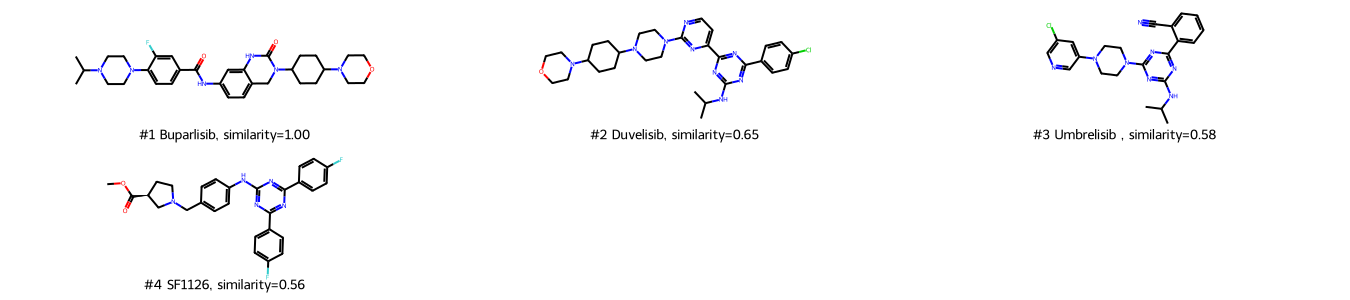

In [11]:
draw_ranked_molecules(molecules, "tanimoto_maccs")

### Morgan fingerprints: Tanimoto similarity and Dice similarity

In [12]:
molecule_query = molecules["morgan"][0]
molecule_list = molecules["morgan"].to_list()

# Calculate similarty values between query and list elements
molecules["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_morgan"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

In [13]:
preview = molecules.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
preview[["name", "tanimoto_morgan", "dice_morgan", "tanimoto_maccs", "dice_maccs"]]

,name,tanimoto_morgan,dice_morgan,tanimoto_maccs,dice_maccs
0,Buparlisib,1.000000,1.000000,1.000000,1.000000
1,Duvelisib,0.272727,0.428571,0.647887,0.786325
2,SF1126,0.220000,0.360656,0.558442,0.716667
3,Umbrelisib,0.163462,0.280992,0.583333,0.736842


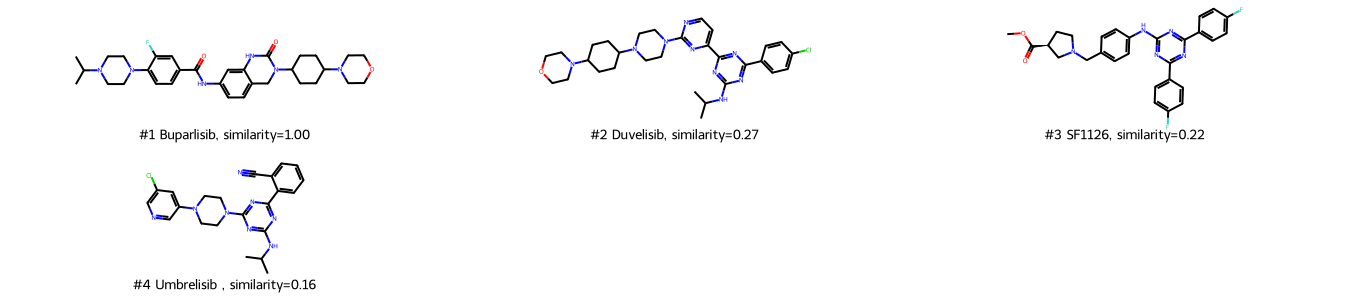

In [14]:
draw_ranked_molecules(molecules, "tanimoto_morgan")

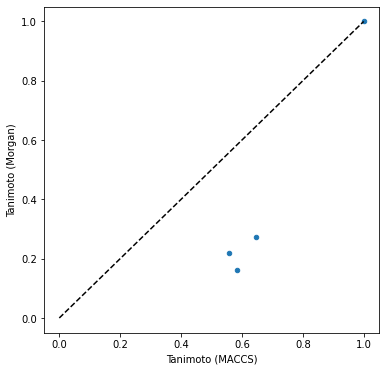

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))
molecules.plot("tanimoto_maccs", "tanimoto_morgan", kind="scatter", ax=ax)
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Tanimoto (MACCS)")
ax.set_ylabel("Tanimoto (Morgan)")
fig;
     

## Virtual screening using similarity search

In [40]:
molecule_dataset = pd.read_csv(
    "data/compounds_lipinski_no_pains.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(f"Number of molecules in dataset: {len(molecule_dataset)}")
molecule_dataset.head(5)

Number of molecules in dataset: 3311


,molecule_chembl_id,smiles,pIC50
0,CHEMBL3660114,Cc1ncc(C#Cc2c(C)ncnc2N2CCOC[C@@H]2C)cc1NS(=O)(...,9.698970
1,CHEMBL3655894,Cc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1c...,9.552842
2,CHEMBL3660127,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,9.522879
3,CHEMBL3660129,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,9.408935
4,CHEMBL1083912,CNC(=O)Nc1ccc2c(c1)C(=O)/C(=C\c1c(-c3c(C)nn(C)...,9.397940


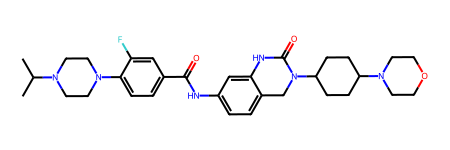

In [43]:
query = Chem.MolFromSmiles("CC(C)N1CCN(CC1)c2ccc(cc2F)C(=O)Nc3ccc4c(c3)NC(=O)N(C4)C5CCC(CC5)N6CCOCC6")
query

In [18]:
# Generate MACCS keys fingerprint
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)

# Generate circular (Morgan) fingerprint
circular_fp_query = rdMolDescriptors.GetMorganFingerprintAsBitVect(query, 2, nBits=1024)

In [19]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = molecule_dataset["ROMol"].apply(generate_morgan_fingerprint).tolist()
maccs_fp_list = molecule_dataset["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()

In [20]:
molecule_dataset["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
    maccs_fp_query, maccs_fp_list
)
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
    circular_fp_query, circular_fp_list
)

In [21]:
molecule_dataset["dice_maccs"] = DataStructs.BulkDiceSimilarity(maccs_fp_query, maccs_fp_list)
molecule_dataset["dice_morgan"] = DataStructs.BulkDiceSimilarity(
    circular_fp_query, circular_fp_list
)

In [22]:
molecule_dataset[
    ["smiles", "tanimoto_maccs", "tanimoto_morgan", "dice_maccs", "dice_morgan"]
].head()

,smiles,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,Cc1ncc(C#Cc2c(C)ncnc2N2CCOC[C@@H]2C)cc1NS(=O)(...,0.549451,0.141593,0.709220,0.248062
1,Cc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1c...,0.539326,0.148148,0.700730,0.258065
2,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,0.585106,0.149123,0.738255,0.259542
3,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,0.541667,0.147826,0.702703,0.257576
4,CNC(=O)Nc1ccc2c(c1)C(=O)/C(=C\c1c(-c3c(C)nn(C)...,0.488095,0.140496,0.656000,0.246377


,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CHEMBL3660114,Cc1ncc(C#Cc2c(C)ncnc2N2CCOC[C@@H]2C)cc1NS(=O)(...,9.698970,,0.549451,0.141593,0.709220,0.248062
1,CHEMBL3655894,Cc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1c...,9.552842,,0.539326,0.148148,0.700730,0.258065
2,CHEMBL3660127,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,9.522879,,0.585106,0.149123,0.738255,0.259542
3,CHEMBL3660129,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,9.408935,,0.541667,0.147826,0.702703,0.257576
4,CHEMBL1083912,CNC(=O)Nc1ccc2c(c1)C(=O)/C(=C\c1c(-c3c(C)nn(C)...,9.397940,,0.488095,0.140496,0.656000,0.246377

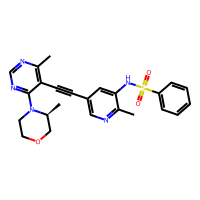
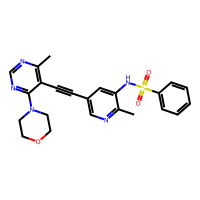
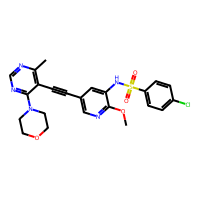
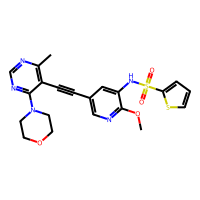
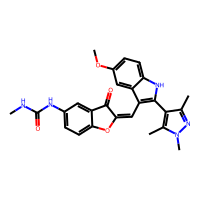

In [23]:
molecule_dataset.head()

### distribution of similarity values

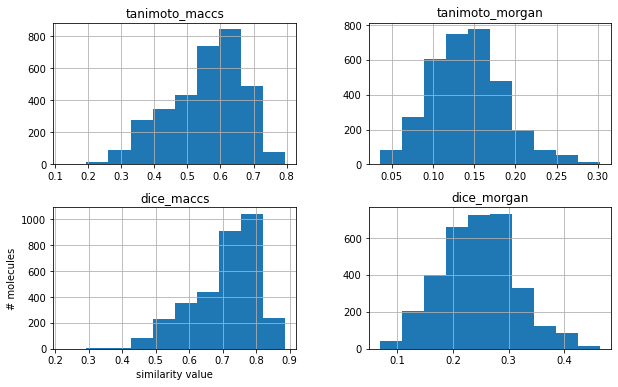

In [24]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
molecule_dataset.hist(["tanimoto_maccs"], ax=axes[0, 0])
molecule_dataset.hist(["tanimoto_morgan"], ax=axes[0, 1])
molecule_dataset.hist(["dice_maccs"], ax=axes[1, 0])
molecule_dataset.hist(["dice_morgan"], ax=axes[1, 1])
axes[1, 0].set_xlabel("similarity value")
axes[1, 0].set_ylabel("# molecules")
fig;

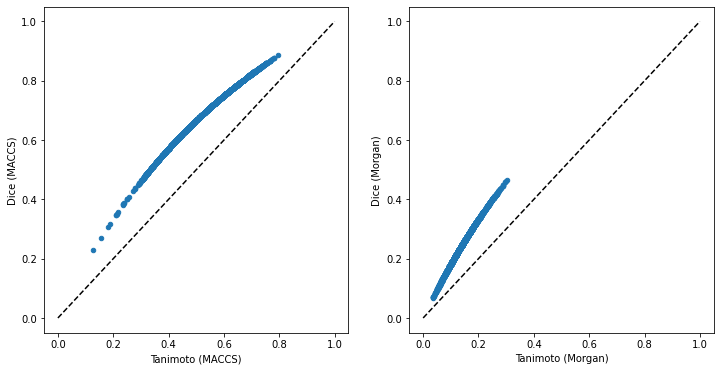

In [25]:
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

molecule_dataset.plot("tanimoto_maccs", "dice_maccs", kind="scatter", ax=axes[0])
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_xlabel("Tanimoto (MACCS)")
axes[0].set_ylabel("Dice (MACCS)")

molecule_dataset.plot("tanimoto_morgan", "dice_morgan", kind="scatter", ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_xlabel("Tanimoto (Morgan)")
axes[1].set_ylabel("Dice (Morgan)")

fig;

### Interpreting Similarity Values

<b>MACCS Keys:</b> These are simpler fingerprints with a limited number of predefined fragments.

<li>Higher similarity (0.8 - 1.0): Suggests strong structural similarity, possibly indicating similar properties and potentially similar biological activity.</li>
<li>Moderate similarity (0.5 - 0.7): May indicate some shared substructures but not necessarily close structural similarity. Further analysis might be needed.</li>
<li>Low similarity (0.0 - 0.4): Likely significant structural differences and potentially distinct bioactivity.</li>

<b>Morgan Fingerprints:<b> These are more complex and capture the local environment around each atom.
<li>Higher similarity (0.7 - 1.0): Indicates significant structural similarity and suggests potentially similar properties and biological activity.</li>
<li>Moderate similarity (0.4 - 0.6): May indicate shared local environments around atoms but not necessarily identical overall structures. More investigation might be required.</li>
<li>Low similarity (0.0 - 0.3): Suggests substantial structural differences and likely distinct bioactivity.</li>

,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
1836,CHEMBL3319489,CC(Nc1ccc(F)c(F)c1)c1cc(C(=O)N(C)C)cn2c(=O)cc(...,6.468521,,0.794521,0.297030,0.885496,0.458015
3096,CHEMBL4110596,CN(C)CCCOc1ccc(-c2cc3c(cc2F)ncc2c3n([C@@H]3CCC...,5.000000,,0.779221,0.196581,0.875912,0.328571
2281,CHEMBL4109764,CN(C)CCCOc1ccc(-c2ccc3ncc4c(c3c2)n([C@@H]2CCCO...,6.071092,,0.779221,0.176471,0.875912,0.300000
2371,CHEMBL3935033,CN(C)CCCOc1ccc(-c2ccc3ncc4c(c3c2)n([C@H]2CCCOC...,5.987163,,0.779221,0.176471,0.875912,0.300000
2500,CHEMBL3318705,Cc1cc(C(C)Nc2cc(Cl)ccc2C(=O)O)c2nc(N3CCOCC3)cc...,5.835647,,0.773333,0.216981,0.872180,0.356589

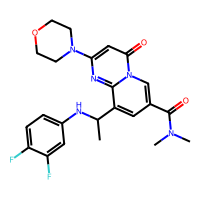
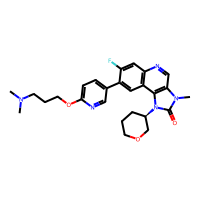
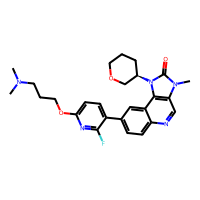
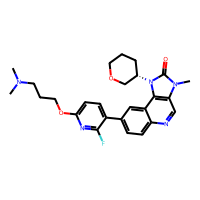
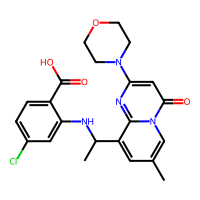

In [26]:
molecule_dataset.sort_values(["dice_maccs"], ascending=False).head()

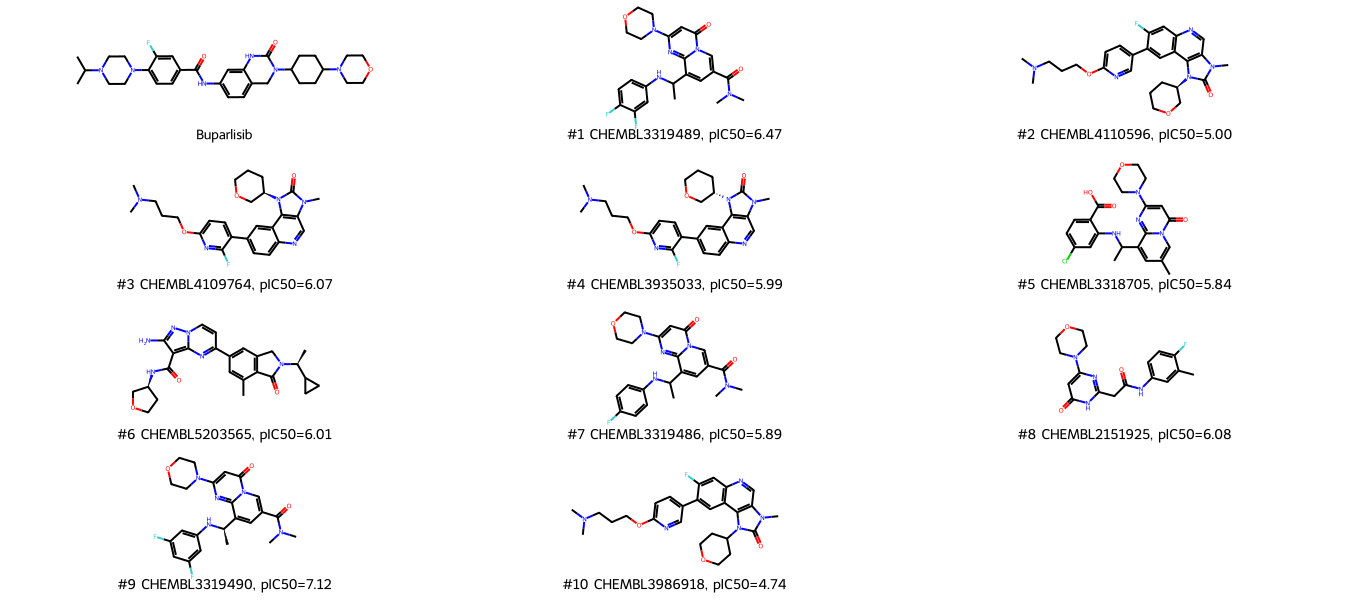

In [27]:
top_n_molecules = 10
top_molecules = molecule_dataset.sort_values(["dice_maccs"], ascending=False).reset_index()
top_molecules = top_molecules[:top_n_molecules]
legends = [
    f"#{index+1} {molecule['molecule_chembl_id']}, pIC50={molecule['pIC50']:.2f}"
    for index, molecule in top_molecules.iterrows()
]
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    legends=(["Buparlisib"] + legends),
    molsPerRow=3,
    subImgSize=(450, 150),
)

## Generate enrichment plot

An enrichment plot visually depicts the percentage of true active molecules identified as we progressively move down the ranked list of molecules (ranked by their similarity scores in this case). A successful virtual screening method should yield a plot where the proportion of active molecules increases rapidly in the top rankings.

The pIC50 value is a measure of a molecule's potency. It represents the negative logarithm of the concentration of a compound required to achieve 50% inhibition of a target biological process.
a pIC50 value of 6.3 or higher means the molecule is potent enough to be considered "active". Molecules below this cutoff are deemed "inactive". This threshold helps us separate the potentially promising compounds from less promising ones.

In [28]:
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    """
    Calculates x and y values for enrichment plot:
        x - % ranked dataset
        y - % true actives identified

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules with similarity values to a query molecule.
    similarity_measure : str
        Column name which will be used to sort the DataFrame．
    pic50_cutoff : float
        pIC50 cutoff value used to discriminate active and inactive molecules.

    Returns
    -------
    pandas.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of identified true actives.
    """

    # Get number of molecules in data set
    molecules_all = len(molecules)

    # Get number of active molecules in data set
    actives_all = sum(molecules["pIC50"] >= pic50_cutoff)

    # Initialize a list that will hold the counter for actives and molecules while iterating through our dataset
    actives_counter_list = []

    # Initialize counter for actives
    actives_counter = 0

    # Note: Data must be ranked for enrichment plots:
    # Sort molecules by selected similarity measure
    molecules.sort_values([similarity_measure], ascending=False, inplace=True)

    # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
    for value in molecules["pIC50"]:
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)
    # Transform number of molecules into % ranked dataset
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

    # Transform number of actives into % true actives identified
    actives_percentage_list = [i / actives_all for i in actives_counter_list]

    # Generate DataFrame with x and y values as well as label
    enrichment = pd.DataFrame(
        {
            "% ranked dataset": molecules_percentage_list,
            "% true actives identified": actives_percentage_list,
        }
    )

    return enrichment

In [46]:
pic50_cutoff = 6.3

In [30]:
similarity_measures = ["tanimoto_maccs", "tanimoto_morgan","dice_maccs","dice_morgan"]
enrichment_data = {
    similarity_measure: get_enrichment_data(molecule_dataset, similarity_measure, pic50_cutoff)
    for similarity_measure in similarity_measures
}
enrichment_data["dice_maccs"].head()

,% ranked dataset,% true actives identified
0,0.000302,0.000424
1,0.000604,0.000847
2,0.000906,0.000847
3,0.001208,0.000847
4,0.001510,0.000847


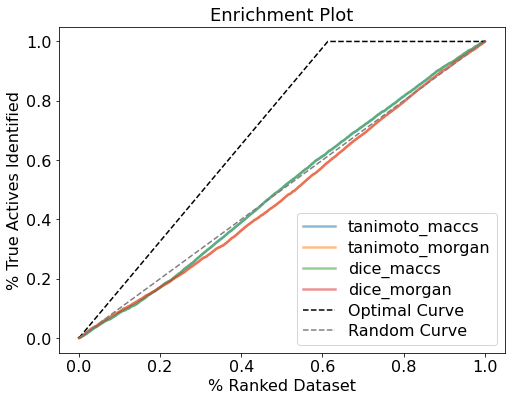

In [47]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Set fontsize
fontsize = 16

# Plot enrichment data
for similarity_measure, enrichment in enrichment_data.items():
    enrichment.plot(
        ax=ax,
        x="% ranked dataset",
        y="% true actives identified",
        label=similarity_measure,
        alpha=0.5,
        linewidth=2.5,
    )

# Set labels and title
ax.set_ylabel("% True Actives Identified", size=fontsize)
ax.set_xlabel("% Ranked Dataset", size=fontsize)
ax.set_title("Enrichment Plot", size=fontsize+2)

# Plot optimal curve: Ratio of actives in dataset
ratio_actives = sum(molecule_dataset["pIC50"] >= pic50_cutoff) / len(molecule_dataset)
ax.plot(
    [0, ratio_actives, 1],
    [0, 1, 1],
    label="Optimal Curve",
    color="black",
    linestyle="--",
)

# Plot random curve
ax.plot([0, 1], [0, 1], label="Random Curve", color="grey", linestyle="--")

# Set ticks and legend
plt.tick_params(labelsize=fontsize)
plt.legend(
    loc="lower right",
    fontsize=fontsize,
    labelspacing=0.3,
)

# Save plot with high resolution
plt.savefig(
    "enrichment_plot.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

# Show plot
plt.show()

In [32]:
def calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff):
    """
    Get the experimental enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    enrichment : pd.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of
        identified true actives.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Experimental enrichment factor.
    """

    # Keep only molecules that meet the cutoff
    enrichment = enrichment[
        enrichment["% ranked dataset"] <= ranked_dataset_percentage_cutoff / 100
    ]
    # Get highest percentage of actives and the corresponding percentage of actives
    highest_enrichment = enrichment.iloc[-1]
    enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
    return enrichment_factor

In [33]:
def calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff):
    """
    Get the random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Random enrichment factor.
    """

    enrichment_factor_random = round(float(ranked_dataset_percentage_cutoff), 1)
    return enrichment_factor_random

In [34]:
def calculate_enrichment_factor_optimal(molecules, ranked_dataset_percentage_cutoff, pic50_cutoff):
    """
    Get the optimal random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    molecules : pandas.DataFrame
        the DataFrame with all the molecules and pIC50.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.
    activity_cutoff: float
        pIC50 cutoff value used to discriminate active and inactive molecules

    Returns
    -------
    float
        Optimal enrichment factor.
    """

    ratio = sum(molecules["pIC50"] >= pic50_cutoff) / len(molecules) * 100
    if ranked_dataset_percentage_cutoff <= ratio:
        enrichment_factor_optimal = round(100 / ratio * ranked_dataset_percentage_cutoff, 1)
    else:
        enrichment_factor_optimal = 100.0
    return enrichment_factor_optimal

In [35]:
ranked_dataset_percentage_cutoff = 5

In [36]:
for similarity_measure, enrichment in enrichment_data.items():
    enrichment_factor = calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff)
    print(
        f"Experimental EF for {ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
    )

Experimental EF for 5% of ranked dataset (tanimoto_maccs): 4.4%
Experimental EF for 5% of ranked dataset (tanimoto_morgan): 4.7%
Experimental EF for 5% of ranked dataset (dice_maccs): 4.4%
Experimental EF for 5% of ranked dataset (dice_morgan): 4.7%


In [37]:
enrichment_factor_random = calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff)
print(
    f"Random EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%"
)
enrichment_factor_optimal = calculate_enrichment_factor_optimal(
    molecule_dataset, ranked_dataset_percentage_cutoff, pic50_cutoff
)
print(
    f"Optimal EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%"
)

Random EF for 5% of ranked dataset: 5.0%
Optimal EF for 5% of ranked dataset: 7.0%


Both Tanimoto-based methods identified active molecules at a slightly lower rate than random selection within the top 5% of the ranked list.
<li>Tanimoto-MACCS: 3.8% vs 5.0% (random)</li>
<li>Tanimoto-Morgan: 4.7% vs 5.0% (random)</li>

Optimal EF: This value represents the ideal scenario where all active molecules are found within the top 5% of the ranked list. It serves as a benchmark for comparison.

Based on the enrichment factors, both Tanimoto-based methods did not effectively prioritize active molecules within the top 5% of the ranked list compared to random selection